<a href="https://colab.research.google.com/github/threewisemonkeys-as/dl_fun/blob/master/atari_env_rl/pong_dqn_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import math, random

import gym
import cv2
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
plt.ion()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Pong Environment

In [0]:
class NoOpResetEnv(gym.Wrapper):
  def __init__(self, env, noop_max=30):
    gym.Wrapper.__init__(self, env)
    self.noop_max = noop_max

  def reset(self, **kwargs):
    self.env.reset(**kwargs)
    for _ in range(random.randint(1, noop_max + 1)):
      obs, _, done, _ = self.env.step(0)
      if done:
        obs = self.env.reset(**kwargs)

    return obs

  def step(self, action):
        return self.env.step(action)



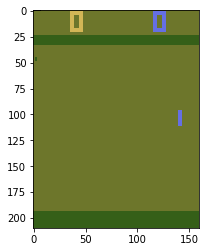

In [0]:
env = gym.make("PongNoFrameskip-v4")
plt.imshow(env.reset())

### Screen Preproccessor

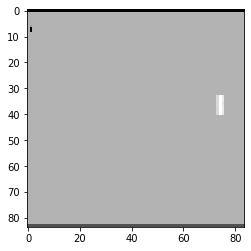

In [0]:
def proccess_screen(frame, gray=True, crop_shape=(32, 195), resize_shape=(84, 84)):
  if gray:
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
  frame = frame[:][crop_shape[0]:crop_shape[1]]
  frame = cv2.resize(frame, resize_shape)
  frame = torch.tensor(frame, dtype=torch.float).unsqueeze(0).unsqueeze(0).to(device)
  return frame

plt.imshow(proccess_screen(env.reset()).squeeze(0).squeeze(0).cpu(), cmap='gray')

### Replay Buffer

In [0]:
Transition = collections.namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

In [0]:
class ReplayBuffer():

  def __init__(self, capacity):
    self.buffer = collections.deque(maxlen=capacity)

  def __len__(self):
    return len(self.buffer)

  def push(self, state, action, next_state, reward, done):
    self.buffer.append(Transition(state, action, next_state, reward, done))

  def sample(self, batch_size):
    state, action, next_state, reward, done = zip(*random.sample(self.buffer, batch_size))
    return torch.cat(state), torch.cat(action), torch.cat(next_state), torch.cat(reward), torch.cat(done)


### Neural Net

In [0]:
class DQN(nn.Module):
  def __init__(self, in_channels, num_outputs):
    super(DQN, self).__init__()
    self.feature_extractor = nn.Sequential(
        nn.Conv2d(in_channels, 32, kernel_size=8, stride=4),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=4, stride=2),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, stride=1),
        nn.ReLU(),
    ) 

    self.dense = nn.Sequential(
        nn.Linear(64*7*7, 512),
        nn.ReLU(),
        nn.Linear(512, num_outputs),
    )

  def forward(self, x):
    x = self.feature_extractor(x)
    x = x.view(x.size(0), -1)
    x = self.dense(x)
    return x

  def act(self, state, epsilon=0):
    if random.random() > epsilon:
      q_values = self.forward(state)
      action = q_values.max(1)[1].view(1, 1)
    else:
      action = torch.tensor([[random.randrange(env.action_space.n)]],
                            device=device)
    return action



In [0]:
model = DQN(1, env.action_space.n).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.00001)
replay_inital = 10_000
replay_buffer = ReplayBuffer(100_000)

### Epsilon Strategy

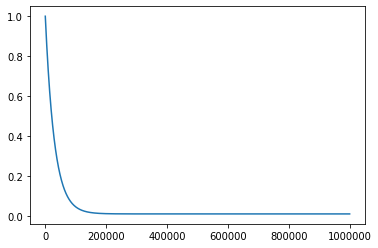

In [0]:
eps_start = 1
eps_final = 0.01
eps_decay = 30_000

eps = lambda i: eps_final + (eps_start - eps_final) * math.exp(-1. * i / eps_decay)

plt.plot([eps(i) for i in range(1_000_000)])

### Training

In [0]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

In [0]:
def optimize(batch_size):
  state, action, next_state, reward, done = replay_buffer.sample(batch_size)

  q_values = model(state).gather(1, action)
  next_q_values = model(next_state).max(1)[0]
  expected_q_values = reward + gamma * next_q_values * (~ done)

  loss = F.smooth_l1_loss(q_values, next_q_values)

  optimizer.zero_grad()
  loss.backward()

  # Clip gradients 
  #for param in policy_net.parameters():
  #    param.grad.data.clamp_(-1, 1)

  optimizer.step()

  return loss

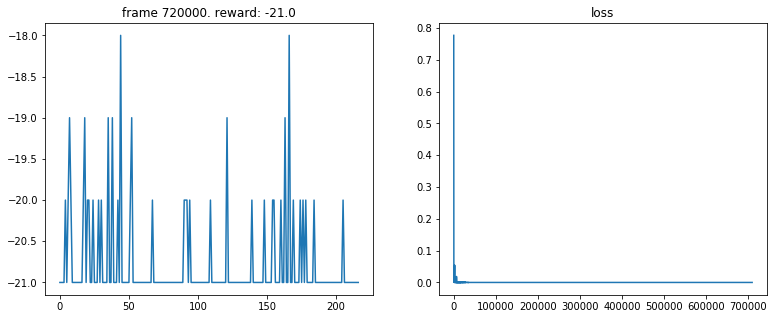

In [0]:
num_frames = 1_400_000
batch_size = 32
gamma = 0.99

losses = []
rewards = []
episode_reward = 0

state = proccess_screen(env.reset())

for i in range(1, num_frames + 1):
  action = model.act(state, epsilon=eps(i))

  next_state, reward, done, _ = env.step(action)
  episode_reward += reward
  next_state = proccess_screen(next_state)
  reward = torch.tensor([reward], device=device)
  done = torch.tensor([done], device=device)
  replay_buffer.push(state, action, next_state, reward, done)
  state = next_state

  if done:
    state = proccess_screen(env.reset())
    rewards.append(episode_reward)
    episode_reward = 0

  if len(replay_buffer) > replay_inital:
    loss = optimize(batch_size)
    losses.append(loss.item())

  if i % 10_000 == 0:
    plot(i, rewards, losses)